<a href="https://colab.research.google.com/drive/1u68Wvo-hUGznpn76ziEJ43zE4Fe8nL6o" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MVP Sprint 4 - Pós Engenharia de Software PUC-RIO - Daniel de Sousa Leite
## Predição de falha no coração
#### Base de dados obtidada do repositório: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data

In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np

# import seaborn as sns  ####

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

#Import de métodos de classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Import de lib para alteração de labels para valores numéricos
from sklearn.preprocessing import LabelEncoder

#Import de lib para exportar modelo
import pickle

## Carga do Dataset

In [2]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/danielsleite/mvp_sprint4/main/heart.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# dataset = pd.read_csv('../heart.csv')

dataset = dataset.drop(index=0)
dataset = dataset.drop(index=1)

# Mostra as primeiras linhas do dataset
print("Dados finais")
dataset.head()

Dados finais


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0


# Pré processamento
#### Imprime a descrição estatística dos itens

In [3]:
#Imprime a descrição estatística dos itens

dataset.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000
mean,53.530568,132.358079,198.721616,0.233624,136.750000,0.888210,0.553493
std,9.431151,18.510152,109.461224,0.423367,25.453606,1.067325,0.497402
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,155.250000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### Verificação de dados nulos

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


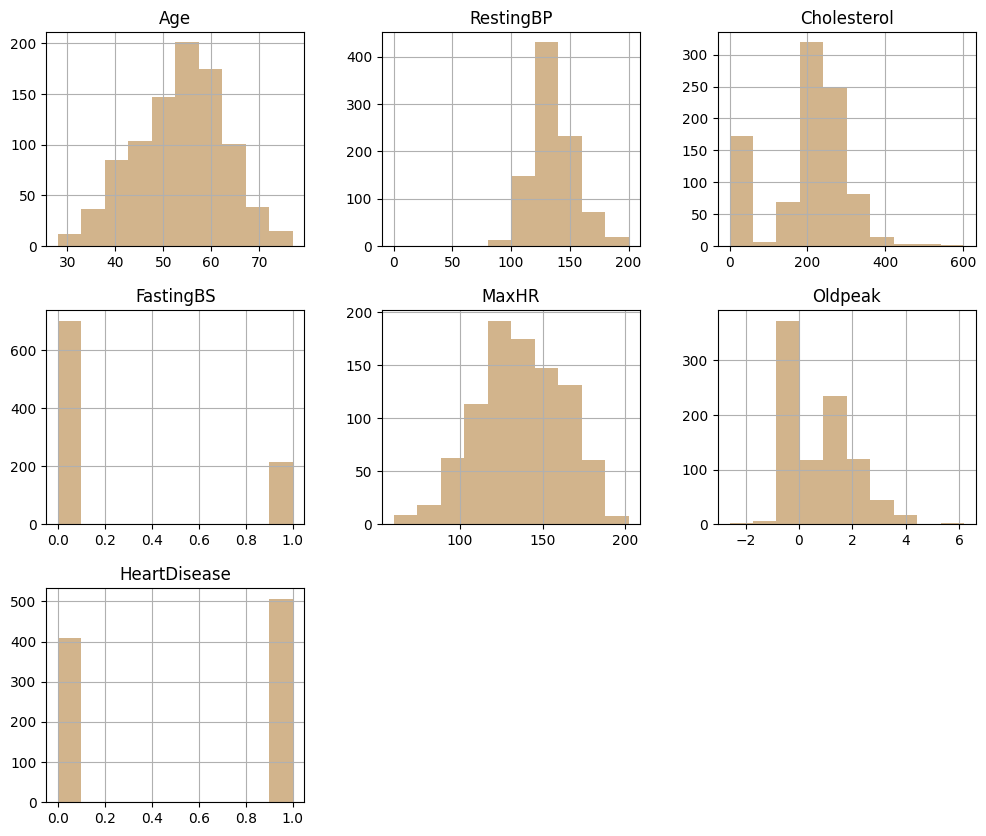

In [4]:
#Printa a contagem de dados ausentes em cada coluna
# print(dataset.isna().sum())
print(dataset.isnull().sum())

#Printa a presença de algum dado faltante na tabela
# print(dataset.isnull().any())

#Exibe o a distribuição dos dados numéricos
dataset.hist(figsize=(12,10),color='tan')
plt.show()

### Análise de outlier

In [5]:
#Com uma breve observação dos dados, a coluna RestingBP representa a pressão arterial inferior. Como valores tão baixos como 0, serão descaratados, pois já ser caracteriza uma condição de doença ou morte, pois não há pressão

#imprime os elementos que antendem a condiação descrita anteriormente
dataset[dataset['RestingBP']==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


### Remoção de outlier


In [6]:
#Remove esses elementos do dataset e imprimo a descrição novoa dos dados estatíticos

dataset.drop(index=dataset[dataset['RestingBP']==0].index,inplace=True)
dataset.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000
mean,53.528962,132.502732,198.938798,0.233880,136.730055,0.887541,0.553005
std,9.436183,17.994795,109.323444,0.423528,25.460364,1.067717,0.497454
min,28.000000,80.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.500000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,155.500000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### Transformação dos dados não numéricos em numéricos

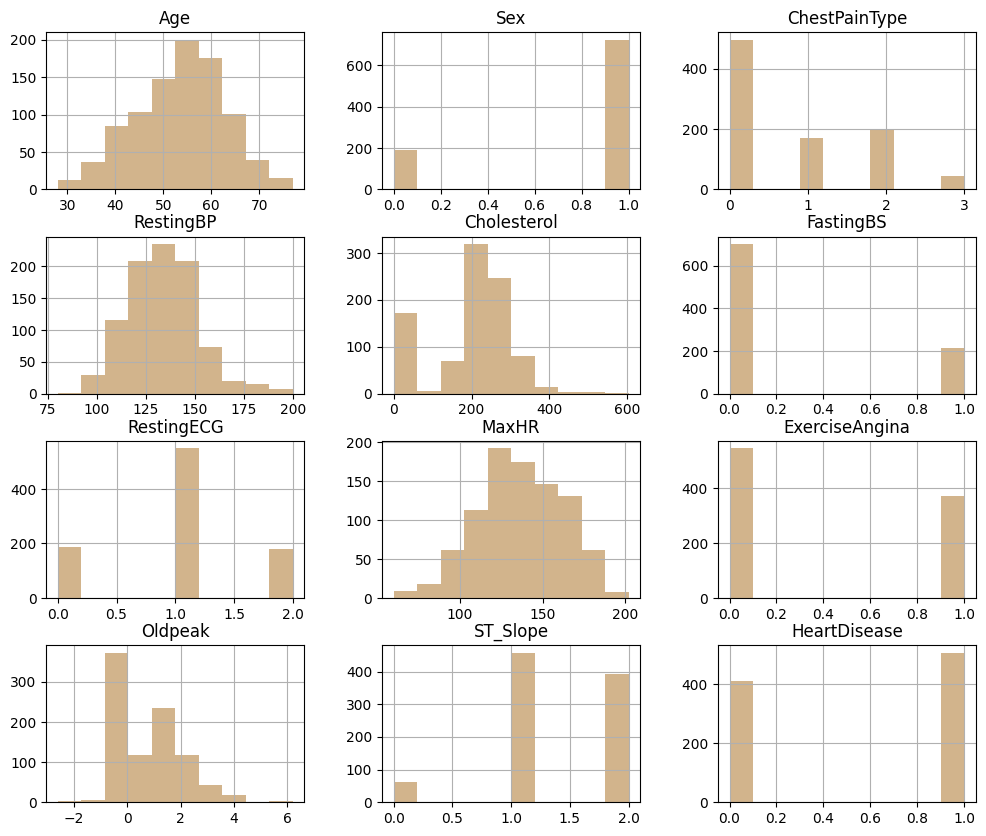

{'F': 0, 'M': 1, 'ASY': 0, 'ATA': 1, 'NAP': 2, 'TA': 3, 'LVH': 0, 'Normal': 1, 'ST': 2, 'N': 0, 'Y': 1, 'Down': 0, 'Flat': 1, 'Up': 2}


In [7]:
#Cria objeto para encodar os valores representados em labels em valores numéricos de 0 à N
le=LabelEncoder()

labels_dict = {}  # cria um dicionario vazio para salvar os labels

dataset["Sex"]=le.fit_transform(dataset["Sex"])
labels_dict.update(dict(zip(le.classes_, range(len(le.classes_)))))
dataset["ChestPainType"]=le.fit_transform(dataset["ChestPainType"])
labels_dict.update(dict(zip(le.classes_, range(len(le.classes_)))))
dataset["RestingECG"]=le.fit_transform(dataset["RestingECG"])
labels_dict.update(dict(zip(le.classes_, range(len(le.classes_)))))
dataset["ExerciseAngina"]=le.fit_transform(dataset["ExerciseAngina"])
labels_dict.update(dict(zip(le.classes_, range(len(le.classes_)))))
dataset["ST_Slope"]=le.fit_transform(dataset["ST_Slope"])
labels_dict.update(dict(zip(le.classes_, range(len(le.classes_)))))
dataset.head()

#Imprime o novo histograma com a distriuição de todos os dados
dataset.hist(figsize=(12,10),color='tan')
plt.show()

# #Imprime o começo da tabela
# dataset.head()

print(labels_dict)

## Separação em conjunto de treino e conjunto de teste com holdout

In [8]:
test_size = 0.30 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:11]
y = array[:,11]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação


## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.675000 (0.057537)
NB: 0.862500 (0.033366)
SVM: 0.718750 (0.046875)
Decision_Tree: 0.834375 (0.035078)
RandomForest: 0.884375 (0.032924)
GradientBoosting: 0.882812 (0.022372)


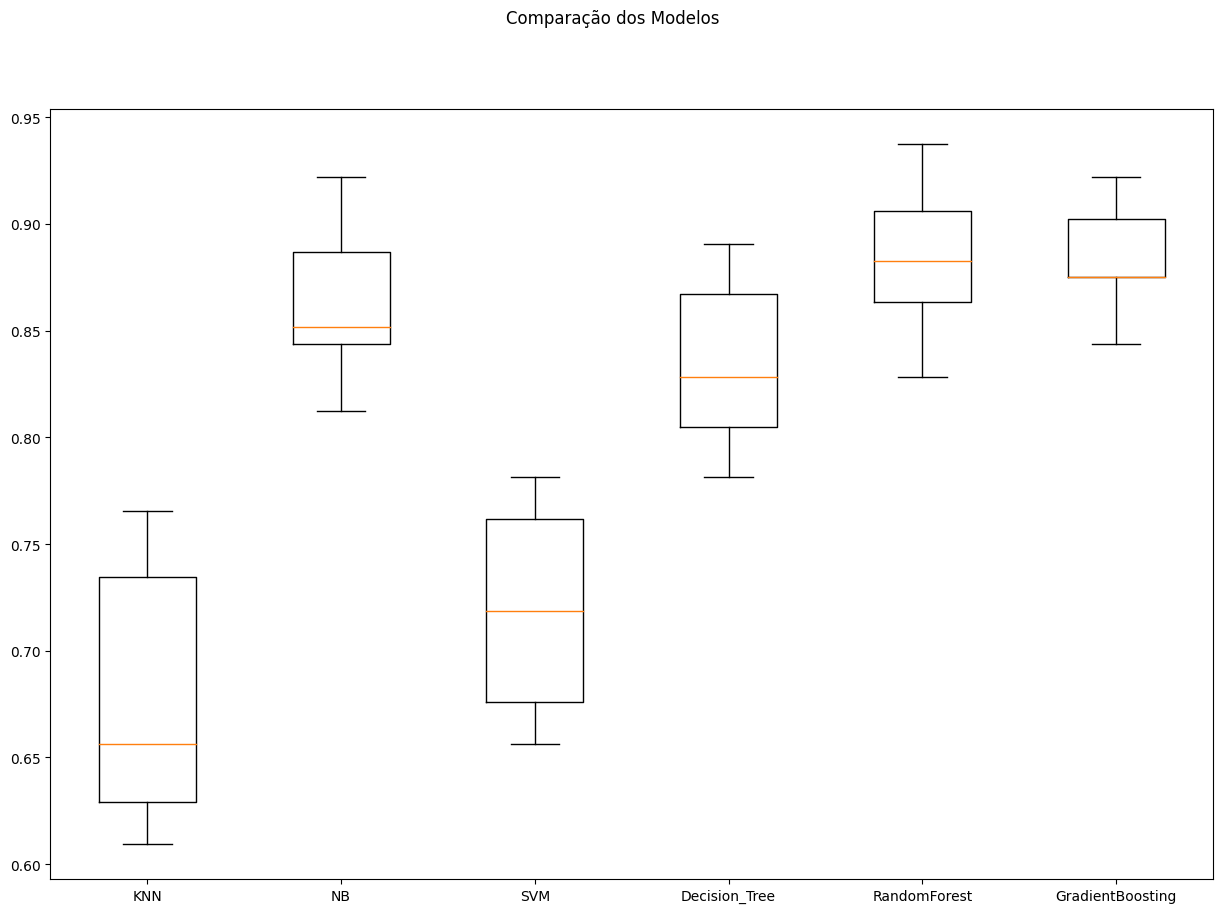

In [9]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('Decision_Tree', DecisionTreeClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('GradientBoosting', GradientBoostingClassifier()))


# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.675 (0.058)
NB-orig: 0.863 (0.033)
gBosting-orig: 0.719 (0.047)
dtree-orig: 0.834 (0.035)
rFor-orig: 0.884 (0.033)
gBosting-orig: 0.883 (0.022)
KNN-padr: 0.875 (0.027)
NB-padr: 0.863 (0.033)
SVM-padr: 0.887 (0.021)
dtree-padr: 0.831 (0.025)
rFor-padr: 0.877 (0.027)
gBosting-padr: 0.881 (0.023)
KNN-norm: 0.858 (0.032)
NB-norm: 0.863 (0.033)
SVM-norm: 0.877 (0.021)
dtree-norm: 0.838 (0.027)
rFor-norm: 0.873 (0.029)
gBosting-norm: 0.883 (0.022)


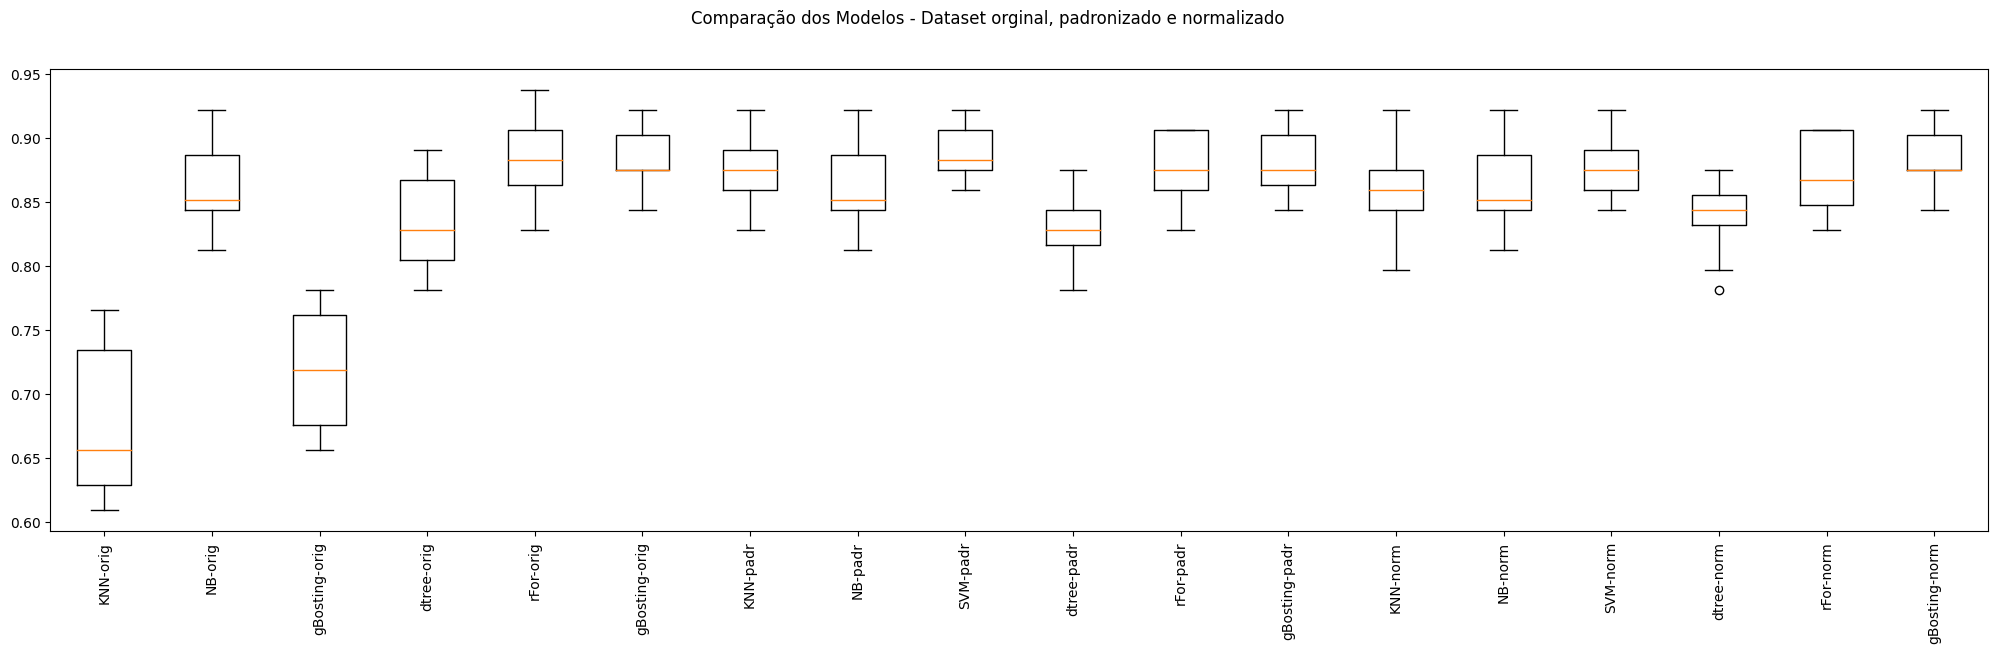

In [10]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
dtree = ('D_Tree', DecisionTreeClassifier())
rFor = ('RandForest', RandomForestClassifier())
gBosting = ('GradBoosting', GradientBoostingClassifier())


# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('gBosting-orig', Pipeline([svm])))
pipelines.append(('dtree-orig', Pipeline([dtree])))
pipelines.append(('rFor-orig', Pipeline([rFor])))
pipelines.append(('gBosting-orig', Pipeline([gBosting])))


# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('dtree-padr', Pipeline([standard_scaler, dtree])))
pipelines.append(('rFor-padr', Pipeline([standard_scaler, rFor])))
pipelines.append(('gBosting-padr', Pipeline([standard_scaler, gBosting])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('dtree-norm', Pipeline([min_max_scaler, dtree])))
pipelines.append(('rFor-norm', Pipeline([min_max_scaler, rFor])))
pipelines.append(('gBosting-norm', Pipeline([min_max_scaler, gBosting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

# print(results[0])

### Otimização dos hiperparâmetros

Fitting 10 folds for each of 33 candidates, totalling 330 fits
Método: KNN-orig - Melhor: 0.757812, std: 0.05099115272525225 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 17}
Soma de resultados NAN dos testes: 0 de 33
Fitting 10 folds for each of 33 candidates, totalling 330 fits
Método: KNN-padr - Melhor: 0.896875, std: 0.02724311839712921 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 15}
Soma de resultados NAN dos testes: 0 de 33
Fitting 10 folds for each of 33 candidates, totalling 330 fits
Método: KNN-norm - Melhor: 0.876563, std: 0.028341183042526648 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 19}
Soma de resultados NAN dos testes: 0 de 33
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Método: SVM-orig - Melhor: 0.846875, std: 0.027775607554111216 usando {'SVM__C': 100, 'SVM__kernel': 'poly'}
Soma de resultados NAN dos testes: 0 de 12
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Método: SVM-padr - Melhor: 0.887500, 

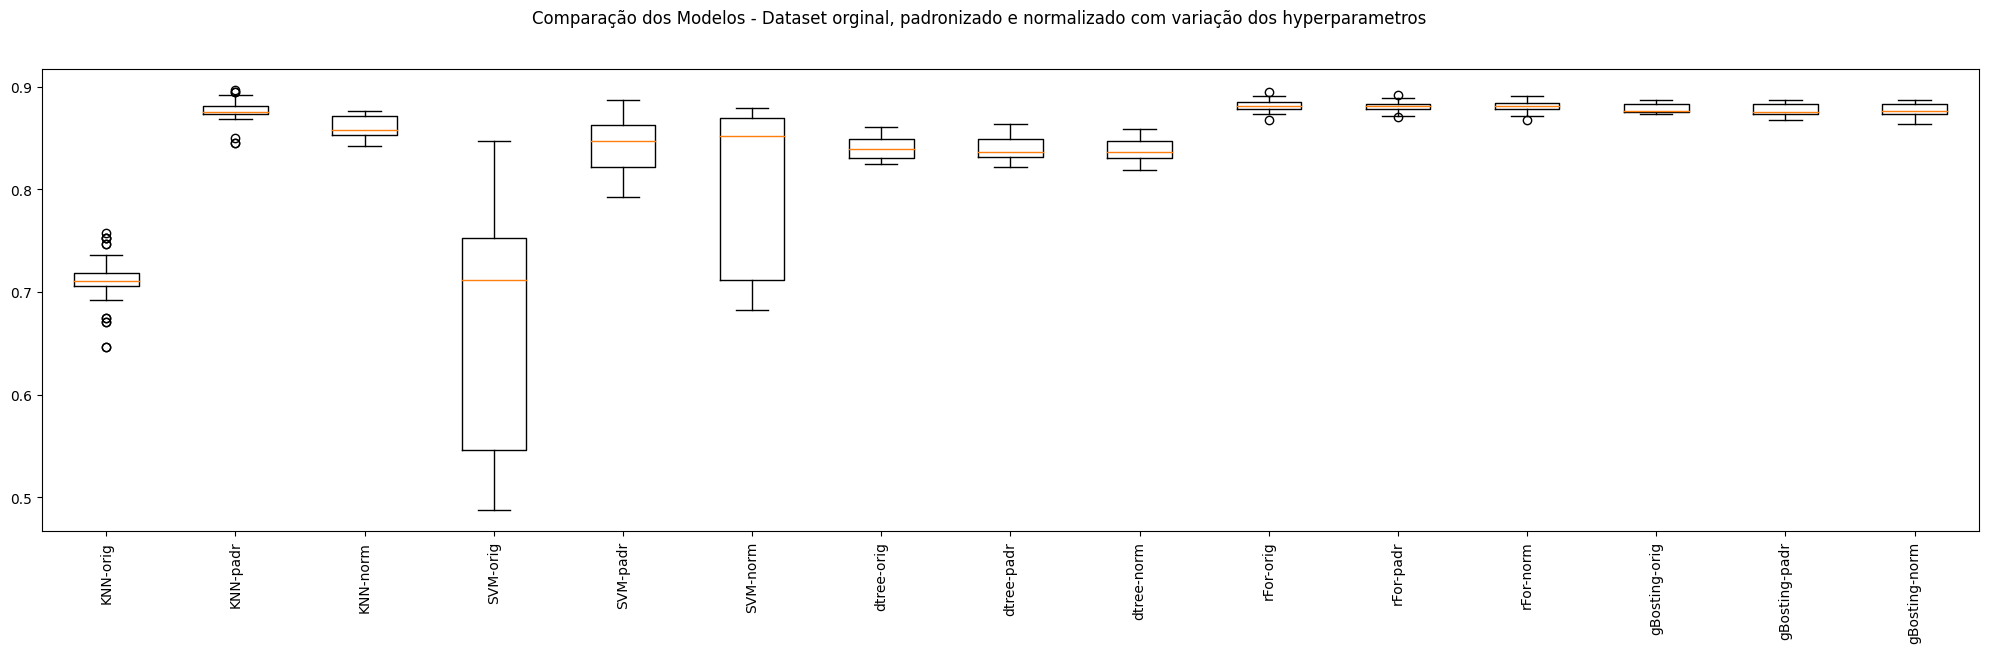

In [11]:
# Com base nos resultado anteriormente obtidos, comparado os métodos com dados originais, padronizados e normalizados, a melhor resposta foi obtitada com o métido Randon Florest com dados normalizados: 0.877 (0.031). Conatudo,
# com a variação dos hiperparâmetros de cada método, esse resultado poderá mudar. Portando, será feita uma nova rodada de comparação, mas agora também variando os hyperparâmetros de cada métodos.


np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline

standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


## Tuning do KNN
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))

## Tuning do SVM
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

## Tuning do Decision Tree
pipelines.append(('dtree-orig', Pipeline([dtree])))
pipelines.append(('dtree-padr', Pipeline([standard_scaler, dtree])))
pipelines.append(('dtree-norm', Pipeline([min_max_scaler, dtree])))

## Tuning do RandomForest
pipelines.append(('rFor-orig', Pipeline([rFor])))
pipelines.append(('rFor-padr', Pipeline([standard_scaler, rFor])))
pipelines.append(('rFor-norm', Pipeline([min_max_scaler, rFor])))

## Tuning do GradientBoosting
pipelines.append(('gBosting-orig', Pipeline([gBosting])))
pipelines.append(('gBosting-padr', Pipeline([standard_scaler, gBosting])))
pipelines.append(('gBosting-norm', Pipeline([min_max_scaler, gBosting])))


#Função auxiliar para rodar o grid em diferentes modelos
def grid_test(modelo, param_grid, scoring, cv, result):
    grid = GridSearchCV(estimator=modelo, param_grid=param_grid, scoring=scoring, cv=cv,verbose=1)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Método: %s - Melhor: %f, std: %s usando %s" % (name, grid.best_score_, grid.cv_results_['std_test_score'][grid.best_index_], grid.best_params_))
    names_hyper.append(name)
    temp = np.array(grid.cv_results_['mean_test_score']) #remove nan, caso exista
    print("Soma de resultados NAN dos testes: %d de %d" % (np.isnan(temp).sum(), len(temp)))
    result.append(temp[np.isfinite(temp)])        #anexa ao vetor, os resultados médios filtrados os valores nan


#Hyperparametros do KNN
param_grid_KNN = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

#Hyperparametros do SVM
param_grid_SVC = {
    'SVM__C': [0.1, 1, 10, 100],
    # 'SVM__gamma': [1, 0.1, 0.01, 0.001],
    'SVM__kernel': ['rbf', 'poly', 'sigmoid']}

#Hyperparametros do Decision Tree
param_grid_DTREE = {
    'D_Tree__criterion' : ['gini', 'entropy'],
    'D_Tree__max_depth': [2,4,6,8,10,12]
}

#Hyperparametros do RandomForest
param_grid_RAND = {
    'RandForest__bootstrap': [True, False],
    'RandForest__max_depth': [10, 40, 80, 100, 120, None],
    'RandForest__max_features': ['auto', 'sqrt'],
    'RandForest__min_samples_split': [2, 5, 10],
    }

#Hyperparametros do GradientBoosting
param_grid_GBOOST = {
    'GradBoosting__loss': ['log_loss', 'exponential'],
    'GradBoosting__max_depth': [1,3,5,7],
    'GradBoosting__criterion': ['friedman_mse', 'squared_error']
}

#Lista para guardar os melhores resultados
results_hyper = []
names_hyper = []

# Executa o GridSearchCV com a função auxliar
for name, model in pipelines:
    if 'KNN' in name:
        grid_test(modelo=model, param_grid=param_grid_KNN, scoring=scoring, cv=kfold, result=results_hyper)
    elif 'SVM' in name:
        grid_test(modelo=model, param_grid=param_grid_SVC, scoring=scoring, cv=kfold, result=results_hyper)

    elif 'dtree' in name:
        grid_test(modelo=model, param_grid=param_grid_DTREE, scoring=scoring, cv=kfold, result=results_hyper)

    elif 'rFor' in name:
        grid_test(modelo=model, param_grid=param_grid_RAND, scoring=scoring, cv=kfold, result=results_hyper)

    elif 'gBosting' in name:
        grid_test(modelo=model, param_grid=param_grid_GBOOST, scoring=scoring, cv=kfold, result=results_hyper)
    else:
        print ("método não cadastrado")

# Exibe o box plot dos resultados do teste
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado com variação dos hyperparametros')
ax = fig.add_subplot(111)
plt.boxplot(results_hyper)
ax.set_xticklabels(names_hyper, rotation=90)
plt.show()



## Finalização do Modelo

In [12]:
# Avaliação do modelo com o conjunto de testes

# Dada os resultados dos testes de alteração do hyperparamtros utilzados, o método que apresentou melhor resposta foi o RandomForestClassifier
# com o conjunto de dados padronizados e com os seguinte hyperparatros:

#Método: rFor-norm - Melhor: 0.890625, std: 0.02614562582918986 usando {'RandForest__bootstrap': False, 'RandForest__max_depth': 80, 'RandForest__max_features': 'sqrt', 'RandForest__min_samples_split': 5}

# Contudo, o mesmo apresentou 36 saídas inválidas nos 72 conjuntos de testes realizado, por esse motivo, também será avalidado o segundo medelo GradientBosting, que apresentou uma performance parecdia com o
# randon florest, mas sem ter respotas com saídas inválidas. Para o caso do Gradiente Boosting, a melhor resposta foi com a configuração abaixo:

# Método: gBosting-norm - Melhor: 0.887500, std: 0.025 usando {'GradBoosting__criterion': 'friedman_mse', 'GradBoosting__loss': 'exponential', 'GradBoosting__max_depth': 3}


# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino

#Cria o modelo com os hyperparâmetros que apresentaram melhor resposta do randon florest
model_rand = RandomForestClassifier(bootstrap=False, max_depth=80,max_features='sqrt',min_samples_split=5)
model_rand.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model_rand.predict(rescaledTestX)
print("Resultado conjunto de teste com Randon Florest: %s" % accuracy_score(y_test, predictions))


# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino

#Cria o modelo com os hyperparâmetros que apresentaram melhor resposta do GradBoosting
model_grad = GradientBoostingClassifier(criterion='friedman_mse',loss='exponential',max_depth=3)
model_grad.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model_grad.predict(rescaledTestX)
print("Resultado conjunto de teste com Gradient Boosting: %s" % accuracy_score(y_test, predictions))

Resultado conjunto de teste com Randon Florest: 0.8363636363636363
Resultado conjunto de teste com Gradient Boosting: 0.8581818181818182


## Realiza o treinamento com toda a base de dados com o método que apresentou melhor performance

In [13]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model_grad.fit(rescaledX, y)

GradientBoostingClassifier(loss='exponential')

## Exportando modelo e scaler para utilziação em aplicação back-end

In [14]:
# Apesar do cenário ideal ser a utilização do modelo treinado com toda a base, por não haver disponibilidade de dados de novos pascientes,
# o conjunto de teste de validação do modelo será utrilizado para reaplizar a rotina de teste do algorítmo com a ferramente pytest.
# Portando, para que o teste seja com dados desconhecidos, o modelo esportado será o treinado sem os dados de teste.
# Também serão exportados os dados de teste para validação do modelo, dentro da aplicação e uso na interface.

# Geradno o modelo e scaler com os dados de treinaemnto

scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino

#Cria o modelo com os hyperparâmetros que apresentaram melhor resposta do GradBoosting
model_grad = GradientBoostingClassifier(criterion='friedman_mse',loss='exponential',max_depth=3)
model_grad.fit(rescaledX, y_train)


#Criando arquivo para salvar modelo
arq_out = open('classificador.pkl','wb')
pickle.dump(model_grad, arq_out)
arq_out.close()

#Criando arquivo para salvar dicionário de conversão
arq_out = open('dicionario.pkl','wb')
pickle.dump(labels_dict, arq_out)
arq_out.close()

#Criando arquivo para salvar scaler
arq_out = open('scaler.pkl','wb')
pickle.dump(scaler, arq_out)
arq_out.close()

#Criando arquivo para salvar dados de teste.
arq_out = open('x_test.pkl','wb')
pickle.dump(X_test, arq_out)
arq_out.close()

#Criando arquivo para salvar dados resuldado dos dados de teste.
arq_out = open('y_test.pkl','wb')
pickle.dump(y_test, arq_out)
arq_out.close()

### Validação dos dados exportados

In [15]:
#Dados serão importados e será feita uma nova predição

arq_in = open('./classificador.pkl','rb')
modelo = pickle.load(arq_in)
arq_in.close();

arq_in = open('./scaler.pkl','rb')
ajuste = pickle.load((arq_in))
arq_in.close()

arq_in = open('./x_test.pkl','rb')
test = pickle.load((arq_in))
arq_in.close()

arq_in = open('./y_test.pkl','rb')
y = pickle.load((arq_in))
arq_in.close()

# Estimativa da acurácia no conjunto de teste
rescaledTest_X = ajuste.transform(test) # aplicação da padronização no conjunto de teste
predictions_ = modelo.predict(rescaledTest_X)
print("Resultado conjunto de teste com Gradient Boosting: %s" % accuracy_score(y, predictions_))

Resultado conjunto de teste com Gradient Boosting: 0.8581818181818182


### Conclusão


Com a execuação dos diverentes modelos, foi possível observar a importância da normalização ou padronização dos dados na execução de modelos de ML. Onde, por exemplo, nos testes realizados com o KNN, obteve-se uma melhora na acurrácai de mais de 10%, quando comparados os dados originais com os dados padronizados.
Outro ponta a se observar, é com relação a variação dos hyperparâmetros dos algorítmos, que permitiu melhorar a resposta geral de cada algorítmo aplicado. Essa otimização se torna fácil, com o uso da função grid_test. Contudo, a exploração de diversos cenário pode se tornar inviável, dado o custo computacional exigido para o processamento dessas possibilidades.

